In [21]:
import imp
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.crop import *

import utils.data_processor as data_processor
imp.reload(data_processor)
from utils.data_processor import *


%config Completer.use_jedi = False

In [32]:
def score(descending_probability_amount_of_fcd: list) -> np.float:
    idx = next((index for index,
                value in enumerate(descending_probability_amount_of_fcd) if value != 0), None)
    if idx == None:
        return 0
    else:
        return (10-idx)*10
    
def calculate_score(brain_path: str,
                    prediction_path: str,
                    label_path: str,
                    crop_size = 64,
                    step_size = 64) -> float:
    
    brain = np.load(brain_path)
    prediction = load_nii_to_array(prediction_path)
    label = np.load(label_path)
    
    if label.sum() == 0:
        return None
    
    sagittal_shape, coronal_shape, axial_shape = brain.shape
    
    deltas = []
    for shape in [sagittal_shape, coronal_shape, axial_shape]:
        if shape % crop_size != 0:
            deltas.append((0, (shape // crop_size + 1) * crop_size - shape))
        else:
            deltas.append((0, 0))

    brain = np.pad(brain, deltas, "constant", constant_values=0)
    prediction = np.pad(prediction, deltas, "constant", constant_values=0)
    label = np.pad(label, deltas, "constant", constant_values=0)

    single_data_dict, center_coords = get_inference_crops(
        {'brains': brain}, crop_size=crop_size, step_size=step_size
    )
    
    df = pd.DataFrame(columns=['probability', 'is_fcd'])

    for i, crop_point in enumerate(center_coords):
        pred_crop = prediction[crop_point[0]:crop_point[0]+crop_size,
                               crop_point[1]:crop_point[1]+crop_size,
                               crop_point[2]:crop_point[2]+crop_size,
                              ]

        label_crop = label[crop_point[0]:crop_point[0]+crop_size,
                         crop_point[1]:crop_point[1]+crop_size,
                         crop_point[2]:crop_point[2]+crop_size,
                        ]
        
        df.loc[i] = [pred_crop.sum(), label_crop.sum()]
        
    df = df.sort_values(by='probability', ascending=False)[:10]
    return score(df.is_fcd.tolist())

In [33]:
allowed_subjects = np.load('raw_data/sub_with_all_data.npy', allow_pickle=True).tolist()

if not allowed_subjects:
    allowed_subdirs = [f"sub-{name[:-4]}" for name in os.listdir(f"raw_data/normalized_label")]
else:
    allowed_subdirs = [f'sub-{name}' for name in allowed_subjects]
    
brains = [[f"raw_data/output/fmriprep/{subdir}/anat/{name}" for name in os.listdir(f"raw_data/output/fmriprep/{subdir}/anat") if name.endswith("Asym_desc-preproc_T1w.nii.gz")] for subdir in os.listdir(f"raw_data/output/fmriprep/") if subdir.count(".") == 0 and subdir.startswith("sub") and subdir in allowed_subdirs]
brains = [item for sublist in brains for item in sublist]
brain_nums = [x.split('/')[3][4:] for x in brains]

In [36]:
EXP_NAME = "2021-10-27_16bs_abscoords_air_cropsize64_epochs400_whole"
BRAIN_TYPE = EXP_NAME.split('_')[-1]

if BRAIN_TYPE == 'whole':
    BRAIN_TYPE = 'full'
    
brains_loaded = [f"dataset_ready_to_use/data_only_usefull_areas/{BRAIN_TYPE}/brains/{num}.npy" for num in tqdm(brain_nums)]
labels_loaded = [f"dataset_ready_to_use/data_only_usefull_areas/{BRAIN_TYPE}/labels/{num}.npy" for num in tqdm(brain_nums)]

df_result = pd.DataFrame(columns=['brain', 'score'])

for brain_index, paths in tqdm(enumerate(zip(brains_loaded, labels_loaded))):
    brain_path, label_path = paths
    prediction_path = f'interpolate/results/brain_{brain_index}/griddata/nearest_{EXP_NAME}.nii.gz'
    metric = calculate_score(brain_path, prediction_path, label_path)
    df_result.loc[brain_index] = [brain_nums[brain_index], metric]

df_result.to_csv(f'results/{EXP_NAME}.csv')

100%|██████████| 81/81 [00:00<00:00, 193914.74it/s]
81it [01:23,  1.03s/it]


In [37]:
df_result.score.mean()

53.7037037037037

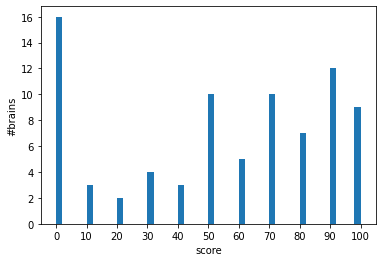

In [38]:
plt.hist(df_result.score,bins=50)
plt.xticks(range(0,110,10))
plt.ylabel('#brains')
plt.xlabel('score')
plt.show()

In [41]:
df_result[df_result.score>=50].score.count()/df_result.score.count()

0.654320987654321

In [42]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import auc

# df_result = pd.DataFrame(columns=['brain', 'auc'])

# for brain_index, paths in tqdm(enumerate(zip(brains_loaded, labels_loaded))):
#     brain_path, label_path = paths
#     prediction_path = f'interpolate/results/brain_{brain_index}/griddata/nearest_{EXP_NAME}.nii.gz'
    
#     brain = np.load(brain_path)
#     prediction = load_nii_to_array(prediction_path)
#     label = np.load(label_path)
    
#     precision, recall, thresholds = precision_recall_curve(label.reshape(-1), prediction.reshape(-1))
#     auc_score = auc(recall, precision)
#     df_result.loc[brain_index] = [brain_nums[brain_index], auc_score]

In [43]:
EXP_NAME = "2021-11-04_16bs_abscoords_air_cropsize64_epochs400_nottemple"
BRAIN_TYPE = EXP_NAME.split('_')[-1]

if BRAIN_TYPE == 'whole':
    BRAIN_TYPE = 'full'
    
brains_loaded = [f"dataset_ready_to_use/data_only_usefull_areas/{BRAIN_TYPE}/brains/{num}.npy" for num in tqdm(brain_nums)]
labels_loaded = [f"dataset_ready_to_use/data_only_usefull_areas/{BRAIN_TYPE}/labels/{num}.npy" for num in tqdm(brain_nums)]

df_result = pd.DataFrame(columns=['brain', 'score'])

for brain_index, paths in tqdm(enumerate(zip(brains_loaded, labels_loaded))):
    brain_path, label_path = paths
    prediction_path = f'interpolate/results/brain_{brain_index}/griddata/nearest_{EXP_NAME}.nii.gz'
    metric = calculate_score(brain_path, prediction_path, label_path)
    df_result.loc[brain_index] = [brain_nums[brain_index], metric]
    
df_result.to_csv(f'results/{EXP_NAME}.csv')

100%|██████████| 81/81 [00:00<00:00, 245475.88it/s]
81it [04:27,  3.30s/it]


In [44]:
df_result.dropna(inplace=True)

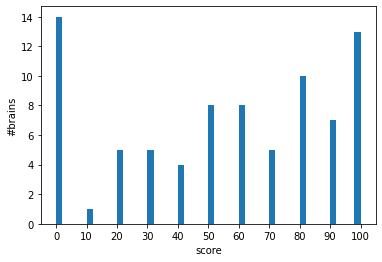

In [45]:
plt.hist(df_result.score,bins=50)
plt.xticks(range(0,110,10))
plt.ylabel('#brains')
plt.xlabel('score')
plt.show()

In [1]:
df_result[df_result.score>=50].score.count()/df_result.score.count()

0.715

In [55]:
nonempty = []
for path in tqdm(labels_loaded):
    label = np.load(path)
    if label.sum() != 0:
        nonempty.append(label.sum())

100%|██████████| 81/81 [00:03<00:00, 22.67it/s]


In [56]:
nonempty

[9308,
 388,
 582,
 949,
 1611,
 4264,
 2178,
 1358,
 3953,
 353,
 3,
 12366,
 14688,
 19794,
 598,
 4719,
 756,
 720,
 2348,
 35,
 2675,
 539,
 7625,
 849,
 2432,
 3753,
 2467,
 4402,
 457,
 97,
 6129,
 9589,
 540,
 1379,
 972,
 2736,
 10320,
 979,
 3946,
 1791,
 8580,
 2238,
 874,
 9123,
 1279,
 31,
 45,
 36,
 6463,
 282,
 1649,
 317,
 1872,
 13457,
 425,
 12519,
 1034,
 1865,
 569,
 276,
 1348,
 5279,
 1573,
 2294,
 7508,
 4932,
 15019,
 165,
 220,
 1314,
 4795,
 2070,
 3153,
 827,
 654,
 4773,
 5434,
 2520,
 509,
 6765]

In [54]:
label.sum()

6765

In [57]:
BRAIN_TYPE = 'whole'

if BRAIN_TYPE == 'whole':
    BRAIN_TYPE = 'full'
    
brains_loaded = [f"dataset_ready_to_use/data_only_usefull_areas/{BRAIN_TYPE}/brains/{num}.npy" for num in tqdm(brain_nums)]
labels_loaded = [f"dataset_ready_to_use/data_only_usefull_areas/{BRAIN_TYPE}/labels/{num}.npy" for num in tqdm(brain_nums)]

100%|██████████| 81/81 [00:00<00:00, 105903.56it/s]


In [58]:
label_amount = []
for path in tqdm(labels_loaded):
    label = np.load(path)
    label_amount.append(label.sum())

100%|██████████| 81/81 [00:02<00:00, 38.11it/s]


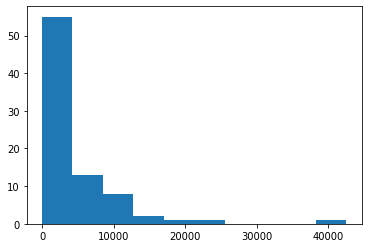

In [59]:
plt.hist(label_amount)
plt.show()

In [60]:
label_amount

[9308,
 388,
 582,
 949,
 1611,
 4264,
 2178,
 1358,
 3953,
 353,
 3,
 12366,
 25002,
 42543,
 2087,
 3735,
 5039,
 756,
 720,
 2348,
 35,
 2675,
 539,
 7625,
 849,
 2432,
 10452,
 8835,
 4402,
 2831,
 97,
 6129,
 9589,
 540,
 1379,
 972,
 2736,
 10320,
 979,
 3946,
 1791,
 8580,
 2238,
 874,
 9123,
 1279,
 2045,
 45,
 36,
 6797,
 282,
 1649,
 317,
 1987,
 16726,
 425,
 13702,
 1034,
 1865,
 569,
 276,
 1348,
 5279,
 1573,
 2294,
 7510,
 4932,
 21000,
 165,
 220,
 1314,
 4795,
 2070,
 3153,
 2397,
 654,
 4773,
 5434,
 2520,
 509,
 8411]